# Fine-tuning a Pretrained Backbone

This notebook demonstrates how to fine-tune a pretrained language model backbone for a specific NLP task. We'll use a pretrained BERT model and fine-tune it on a sentiment analysis dataset. This process allows us to leverage the knowledge from pre-training while adapting the model to our specific classification task.

## Loading and Preparing the Dataset

In this section, we'll load the IMDB movie reviews dataset, which contains 50,000 movie reviews labeled as positive or negative. We'll prepare this data for fine-tuning our BERT model by preprocessing the text and creating appropriate training batches.

In [2]:
import tensorflow as tf
import keras_nlp
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Check versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras NLP version: {keras_nlp.__version__}")

# Load the IMDB dataset from tensorflow_datasets
train_ds, test_ds = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    batch_size=32
)

# Check a sample from the dataset
for review_batch, label_batch in train_ds.take(1):
    for i in range(3):  # Print 3 examples
        print(f"Review: {review_batch[i].numpy().decode('utf-8')[:100]}...")
        print(f"Label: {'Positive' if label_batch[i].numpy() == 1 else 'Negative'}")
        print("-" * 50)

# Prepare the datasets - shuffle and cache for better performance
BUFFER_SIZE = 10000
train_ds = train_ds.shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

TensorFlow version: 2.18.0
Keras NLP version: 0.18.1


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.LDZKT1_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.LDZKT1_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.LDZKT1_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...
Label: Negative
--------------------------------------------------
Review: I have been known to fall asleep during films, but this is usually due to a combination of things in...
Label: Negative
--------------------------------------------------
Review: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn...
Label: Negative
--------------------------------------------------


## Fine-tuning the Pretrained BERT Model

In this section, we'll load a pretrained BERT model and fine-tune it on our IMDB sentiment dataset. We'll use the smaller BERT-tiny model to make training faster, while still benefiting from its pretrained knowledge.

100%|██████████| 507/507 [00:00<00:00, 1.35MB/s]


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 69ms/step - accuracy: 0.7135 - loss: 0.5216 - val_accuracy: 0.8735 - val_loss: 0.3023
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 56ms/step - accuracy: 0.9028 - loss: 0.2511 - val_accuracy: 0.8799 - val_loss: 0.2905
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.9391 - loss: 0.1674 - val_accuracy: 0.8465 - val_loss: 0.4138


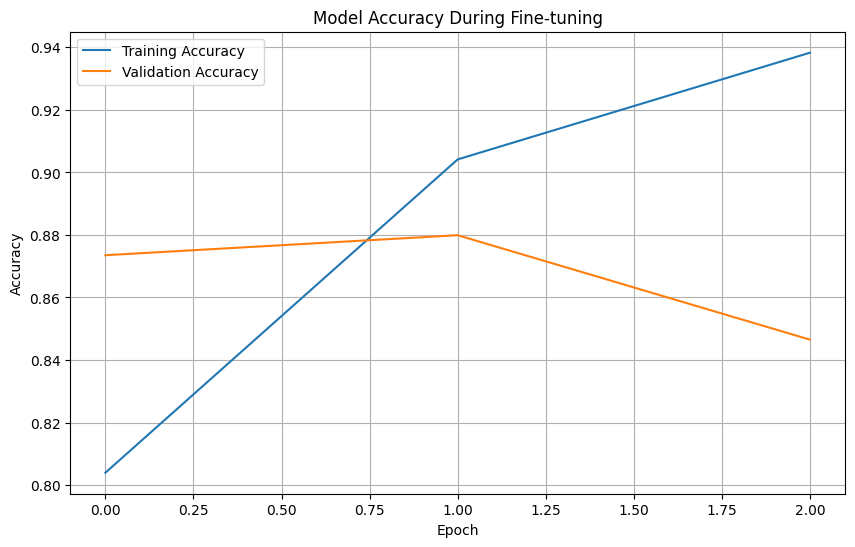

In [3]:
# Define preprocessing layer for BERT
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_tiny_en_uncased",
    sequence_length=512
)

# Load a pretrained BERT backbone for classification
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    preprocessor=preprocessor,
    num_classes=2
)

# Compile the model - we'll use a smaller learning rate for fine-tuning
classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Fine-tune the model - we'll use a smaller number of epochs for demonstration
history = classifier.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,  # You would use more epochs in a real scenario
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy During Fine-tuning")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Testing the Fine-tuned Model

Now let's evaluate our fine-tuned model on some new examples to see how well it performs on sentiment analysis tasks.

In [4]:
# Define some test examples
test_examples = [
    "This movie was simply amazing. The plot twists kept me engaged throughout.",
    "The acting was terrible and the dialogue was even worse. Complete waste of time.",
    "The cinematography was beautiful, but the pacing was too slow for my taste.",
    "I can't decide if I liked it or not, it had both good and bad moments."
]

# Predict using the fine-tuned model
predictions = classifier.predict(test_examples)
pred_classes = np.argmax(predictions, axis=1)

# Display results
for text, pred_class, pred in zip(test_examples, pred_classes, predictions):
    sentiment = "Positive" if pred_class == 1 else "Negative"
    confidence = tf.nn.softmax(pred)[pred_class].numpy()
    print(f"Text: {text}")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 70)

# Evaluate on the test dataset
evaluation = classifier.evaluate(test_ds)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Text: This movie was simply amazing. The plot twists kept me engaged throughout.
Prediction: Positive (Confidence: 0.9930)
----------------------------------------------------------------------
Text: The acting was terrible and the dialogue was even worse. Complete waste of time.
Prediction: Negative (Confidence: 0.9941)
----------------------------------------------------------------------
Text: The cinematography was beautiful, but the pacing was too slow for my taste.
Prediction: Negative (Confidence: 0.9516)
----------------------------------------------------------------------
Text: I can't decide if I liked it or not, it had both good and bad moments.
Prediction: Positive (Confidence: 0.6184)
----------------------------------------------------------------------
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8442 - loss: 0.4180
Test Loss: 0.4138
Test Accuracy: 0.8465
